# Ensemble Challenge (18-month Evaluation)

## Timepoint: July 19, 2021. 

## Setting: New York State upon the arrival of the Delta variant. Vaccines available

In [ ]:
# TODO: 
# - collect and process data DONE
# - collect 3 candidate models DONE
# - set parameter values/uncertainty DONE
# - create observables for cumulative cases, hospitalizations, and deaths DONE
# - calibrate models independently
# - calibrate ensemble of multiple models 
# - improve calibration with more data
# - plot and post-process results

### Load dependencies

In [1]:
import pandas as pd

import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

# Process data

In [2]:
location = "New York"
BETTER_NAMES = {'Cases': 'Infected',
                'Hospitalizations': 'Hospitalized',
                'Deaths': 'Dead'}
## instantiate, making sure no dates are skipped between start and end (could be found dynamically)
full_dataset = pd.DataFrame({'date':pd.date_range(start='1/22/2020', end='3/29/2024')})

## fill the instantiated dataset
for i in ['Cases','Hospitalizations','Deaths']:
    all_data = pd.read_csv(f'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20{i}.csv')
    subset   = all_data[all_data.location_name == location].groupby("date")["value"].sum().reset_index()
    subset.date = pd.to_datetime(subset.date)
    subset['cumsum'] = subset.value.cumsum()
    full_dataset = full_dataset.merge(subset[['date','cumsum']], how='outer', on='date').rename(columns={'cumsum':BETTER_NAMES[i]})

full_dataset[(full_dataset.date >= '2021-06-01') & (full_dataset.date < '2021-09-06')].reset_index(drop=True).reset_index(names=['Timestamp']).drop(['date'],axis=1)

/var/folders/z_/l_q4g1892pqd5g0p2z2f66_m0000gn/T/ipykernel_94093/1662286354.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(f'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20{i}.csv')
/var/folders/z_/l_q4g1892pqd5g0p2z2f66_m0000gn/T/ipykernel_94093/1662286354.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(f'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20{i}.csv')


,Timestamp,Infected,Hospitalized,Dead
0,0,2102869.0,136862.0,53123.0
1,1,2103269.0,136968.0,53132.0
2,2,2103768.0,137089.0,53151.0
3,3,2104539.0,137179.0,53207.0
4,4,2105375.0,137249.0,53221.0
...,...,...,...,...
92,92,2282836.0,150175.0,54282.0
93,93,2288001.0,150497.0,54333.0
94,94,2293966.0,150813.0,54361.0
95,95,2297642.0,151101.0,54378.0


### Define a function to select a subset of the data

In [3]:
def get_data_between(start='2021-06-01',end='2021-09-06'):
    return full_dataset[(full_dataset.date >= start) & (full_dataset.date < end)].reset_index(drop=True).reset_index(names=['Timestamp']).drop(['date'],axis=1)

dataset = get_data_between('2021-06-01', '2021-09-06')
# dataset

### Define a function to plot results

In [4]:
def plot_results_and_data(results, data):
    # Plot the result for cumulative cases, hospitalizations, and deaths
    nice_labels={"deceased_state": "Deaths", "Cumulative_hosp_state": "Cumul Hosp", "Cumulative_cases_state": "Cumul Cases"}
    schema = plots.trajectories(results["data"], 
                                keep=["deceased_state", "Cumulative_hosp_state", "Cumulative_cases_state"], 
                                relabel=nice_labels,
                                points=data.drop(columns=['Timestamp']).reset_index(drop=True)
                               )
    # plots.save_schema(schema, "_schema.json")
    # plots.ipy_display(schema, dpi=150)
    return schema

def plot_all_results(results):
    # Plot the result for all state variables
    schema = plots.trajectories(results["data"], keep=".*_state")
    return schema

# Gather models

In [5]:
# See `Model_Kitchen.ipynb` for model derivation
model1 = "SEIRHD_age_structured_petrinet.json"
model2 = "SEIRHD_vacc_var_petrinet.json"
model3 = "SEIRHD_time_varying_transmission_petrinet.json"

### Define solution mappings for each model

In [6]:
def solution_mapping(model_solution: dict) -> dict:
    # solution mapping for model1 and model2 and model3 (they all have the same set of observables)
    mapped_dict = {}
    mapped_dict["Susceptible"] = model_solution["susceptible"]
    mapped_dict["Exposed"] = model_solution["exposed"]
    mapped_dict["Infected"] = model_solution["infected"]
    mapped_dict["Recovered"] = model_solution["recovered"]
    mapped_dict["Hospitalized"] = model_solution["hospitalized"]
    mapped_dict["Deceased"] = model_solution["deceased"]
    mapped_dict["Cumulative_cases"] = model_solution["all_cases"]
    mapped_dict["Cumulative_hosp"] = model_solution["all_hosp"]
    return mapped_dict

### Set model paths and parameters for sampling

In [7]:
num_iterations = 50 # 500
num_samples = 100
start_time = 0.0
logging_step_size = 10.0

single_model_paths = [[model1], [model2], [model3]]
model_paths = [model1, model2]

single_solution_mapping = [lambda x : x]
solution_mappings = [solution_mapping, solution_mapping, solution_mapping]

single_data_mapping = {'Infected': 'Cumulative_cases', 'Hospitalized': 'Cumulative_hosp', 'Dead': 'deceased'}
data_mapping = {'Infected': 'Cumulative_cases', 'Hospitalized': 'Cumulative_hosp', 'Dead': 'Deceased'}

# (1) Forecast 1: 07/19/2021 - 08/16/2021

In [8]:
dataset = get_data_between('2021-06-01', '2021-07-18')
end_time = len(dataset) + 29.0

## (A) Calibrate each model as an ensemble of a single model 

### Model 1

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 46 rows of data. The first column, Timestamp, begins at 0 and ends at 46. The subsequent columns are named: Infected, Hospitalized, Dead


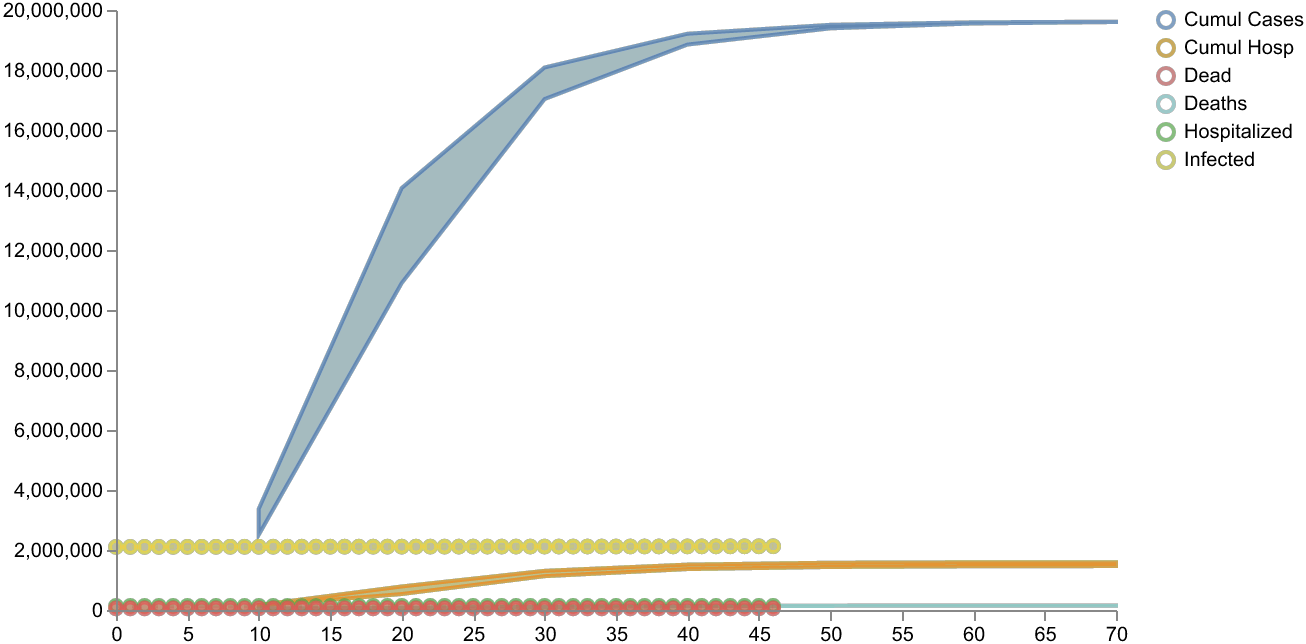

In [9]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[0], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[0], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [15]:
calibrated_ensemble_result["ensemble_quantiles"]

,timepoint_id,inc_cum,output,type,quantile,value
0,0,cum,model_0/Cumulative_cases_state,quantile,0.010,2.495579e+06
1,0,cum,model_0/Cumulative_cases_state,quantile,0.025,2.508515e+06
2,0,cum,model_0/Cumulative_cases_state,quantile,0.050,2.514914e+06
3,0,cum,model_0/Cumulative_cases_state,quantile,0.100,2.559195e+06
4,0,cum,model_0/Cumulative_cases_state,quantile,0.150,2.615058e+06
...,...,...,...,...,...,...
9011,6,inc,all_hosp_state,quantile,0.850,1.560245e+06
9012,6,inc,all_hosp_state,quantile,0.900,1.571054e+06
9013,6,inc,all_hosp_state,quantile,0.950,1.593525e+06
9014,6,inc,all_hosp_state,quantile,0.975,1.607477e+06


In [16]:
display(calibrated_ensemble_result["ensemble_quantiles"])
from pyciemss.integration_utils.result_processing import cdc_format

q_ensemble_data = cdc_format(
    calibrated_ensemble_result["ensemble_quantiles"],
    solution_string_mapping={
        "infected_state": "cases",
        "hospitalized_state": "hosp.",
        "dead_state": "death",
    },
    forecast_start_date="2023-08-03",
    location="US",
    drop_column_names=[
        "timepoint_id",
        "number_days",
        "inc_cum",
        "output",
        "Forecast_Backcast",
    ],
    time_unit="days",
    train_end_point=10.,
)
print("CDC Format:")
display(q_ensemble_data)

,timepoint_id,inc_cum,output,type,quantile,value
0,0,cum,model_0/Cumulative_cases_state,quantile,0.010,2.495579e+06
1,0,cum,model_0/Cumulative_cases_state,quantile,0.025,2.508515e+06
2,0,cum,model_0/Cumulative_cases_state,quantile,0.050,2.514914e+06
3,0,cum,model_0/Cumulative_cases_state,quantile,0.100,2.559195e+06
4,0,cum,model_0/Cumulative_cases_state,quantile,0.150,2.615058e+06
...,...,...,...,...,...,...
9011,6,inc,all_hosp_state,quantile,0.850,1.560245e+06
9012,6,inc,all_hosp_state,quantile,0.900,1.571054e+06
9013,6,inc,all_hosp_state,quantile,0.950,1.593525e+06
9014,6,inc,all_hosp_state,quantile,0.975,1.607477e+06


KeyError: 'number_days'

### Model 2

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[1], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[1], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## (B) Calibrate an ensemble of multiple models

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset, 
                                                 data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, 
                                           logging_step_size, num_samples, start_time=start_time)

## Display results
# display(ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# (2) Forecast 2: 07/26/2021 - 08/23/2021

In [ ]:
dataset = get_data_between('2021-06-01', '2021-07-25')
end_time = len(dataset) + 29.0

## (A) Calibrate an ensemble of a single model

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[1], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[1], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## (B) Calibrate an ensemble of multiple models

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset, 
                                                 data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, 
                                           logging_step_size, num_samples, start_time=start_time)

## Display results
# display(ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# (3) Forecast 3: 08/02/2021 - 08/30/2021

In [ ]:
dataset = get_data_between('2021-06-01', '2021-08-01')
end_time = len(dataset) + 29.0

## (A) Calibrate an ensemble of a single model

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[1], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[1], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## (B) Calibrate an ensemble of multiple models

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset, 
                                                 data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, 
                                           logging_step_size, num_samples, start_time=start_time)

## Display results
# display(ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# (4) Forecast 4: 08/09/2021 - 09/06/2021

In [ ]:
dataset = get_data_between('2021-06-01', '2021-08-08')
end_time = len(dataset) + 29.0

## (A) Calibrate an ensemble of a single model

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[1], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[1], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## (B) Calibrate an ensemble of multiple models

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset, 
                                                 data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, 
                                           logging_step_size, num_samples, start_time=start_time)

## Display results
# display(ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)